In [1]:
import tensorflow as tf
from PIL import Image
from nets import nets_factory
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 批次大小
BATCH_SIZE = 1
# tf文件
TFRECORD_TEST_FILE = 'captcha/test.tfrecord'
CHAR_SET_LEN = 10

In [3]:
def read_and_decode(filename):
    # 根据文件名生成一个队列
    filename_queue = tf.train.string_input_producer([filename])
    reader = tf.TFRecordReader()
    # 返回文件名和文件
    _, serialized_example = reader.read(filename_queue)   
    features = tf.parse_single_example(serialized_example,
                                       features={
                                           'image' : tf.FixedLenFeature([], tf.string),
                                           'label0': tf.FixedLenFeature([], tf.int64),
                                           'label1': tf.FixedLenFeature([], tf.int64),
                                           'label2': tf.FixedLenFeature([], tf.int64),
                                           'label3': tf.FixedLenFeature([], tf.int64),
                                       })
    # 获取图片数据
    image = tf.decode_raw(features['image'], tf.uint8)
    # 没有经过预处理的灰度图
    image_raw = tf.reshape(image, [224, 224])
    # tf.train.shuffle_batch必须确定shape
    image = tf.reshape(image, [224, 224])
    # 图片预处理
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.subtract(image, 0.5)
    image = tf.multiply(image, 2.0)
    # 获取label
    label0 = tf.cast(features['label0'], tf.int32)
    label1 = tf.cast(features['label1'], tf.int32)
    label2 = tf.cast(features['label2'], tf.int32)
    label3 = tf.cast(features['label3'], tf.int32)

    return image, image_raw, label0, label1, label2, label3

INFO:tensorflow:Restoring parameters from captcha/model/crack_captcha.model-1358


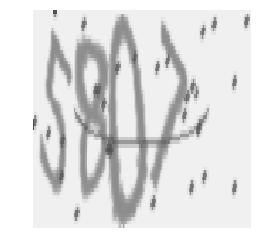

label: [5] [8] [0] [7]
predict: [5] [8] [0] [7]


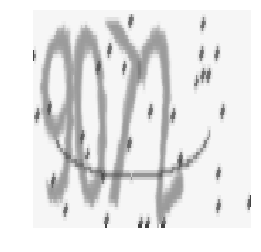

label: [9] [0] [7] [2]
predict: [9] [0] [7] [2]


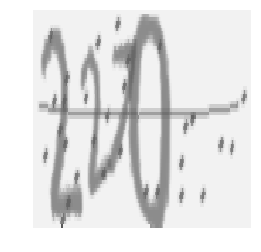

label: [2] [2] [7] [0]
predict: [2] [2] [1] [0]


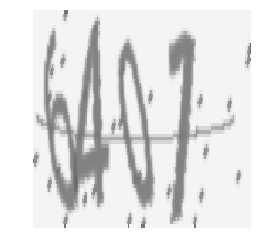

label: [6] [4] [0] [1]
predict: [6] [4] [0] [1]


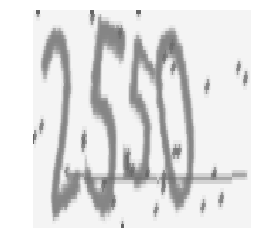

label: [2] [5] [5] [0]
predict: [2] [5] [5] [0]


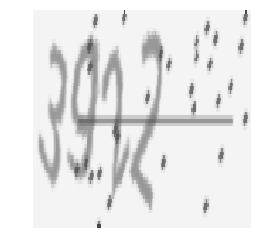

label: [3] [9] [2] [2]
predict: [3] [9] [7] [2]


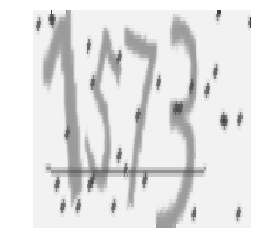

label: [1] [5] [7] [3]
predict: [1] [5] [7] [3]


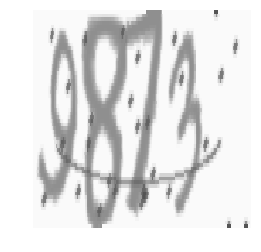

label: [9] [8] [7] [3]
predict: [9] [8] [7] [9]


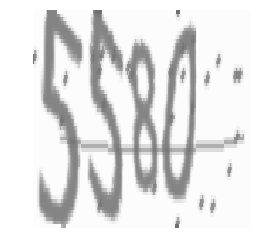

label: [5] [5] [8] [0]
predict: [5] [5] [8] [0]


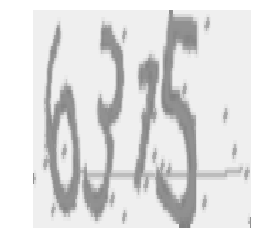

label: [6] [3] [1] [5]
predict: [6] [3] [1] [5]


In [4]:
# 获取图片数据和标签
image, image_raw, label0, label1, label2, label3 = read_and_decode(TFRECORD_TEST_FILE)

#使用shuffle_batch可以随机打乱
image_batch, image_raw_batch, label_batch0, label_batch1, label_batch2, label_batch3 = tf.train.shuffle_batch(
        [image, image_raw, label0, label1, label2, label3], batch_size = BATCH_SIZE,
        capacity = 1000, min_after_dequeue=200, num_threads=1)

#定义网络结构
train_network_fn = nets_factory.get_network_fn(
    'alexnet_v2_captcha_multi',
    num_classes=CHAR_SET_LEN,
    weight_decay=0.0005,
    is_training=False)

# placeholder
x = tf.placeholder(tf.float32, [None, 224, 224])  

# inputs: a tensor of size [batch_size, height, width, channels]
X = tf.reshape(x, [BATCH_SIZE, 224, 224, 1])
# 数据输入网络得到输出值
logits0,logits1,logits2,logits3,end_points = train_network_fn(X)

# 预测值
predict0 = tf.reshape(logits0, [-1, CHAR_SET_LEN])  
predict0 = tf.argmax(predict0, 1)  

predict1 = tf.reshape(logits1, [-1, CHAR_SET_LEN])  
predict1 = tf.argmax(predict1, 1)  

predict2 = tf.reshape(logits2, [-1, CHAR_SET_LEN])  
predict2 = tf.argmax(predict2, 1)  

predict3 = tf.reshape(logits3, [-1, CHAR_SET_LEN])  
predict3 = tf.argmax(predict3, 1)  

saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,'captcha/model/crack_captcha.model-1358')
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    for i in range(10):
        # 获取一个批次的数据和标签
        b_image, b_image_raw, b_label0, b_label1 ,b_label2 ,b_label3 = sess.run([image_batch, 
                                                                    image_raw_batch, 
                                                                    label_batch0, 
                                                                    label_batch1, 
                                                                    label_batch2, 
                                                                    label_batch3])
        # 显示图片
        img=Image.fromarray(b_image_raw[0],'L')
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        # 打印标签
        print('label:',b_label0, b_label1 ,b_label2 ,b_label3)
        # 预测
        label0,label1,label2,label3 = sess.run([predict0,predict1,predict2,predict3], feed_dict={x: b_image})
        # 打印预测值
        print('predict:',label0,label1,label2,label3) 
    coord.request_stop()
    coord.join(threads)